<a href="https://colab.research.google.com/github/RiveraLovo/cuaderno-de-programacion/blob/main/geovanny_semana_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
#Descargar set de datos de Fashion MNIST de Zalando
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incomplete2WIWSY/fashion_mnist-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incomplete2WIWSY/fashion_mnist-test.tfrecord*...:   0%|   …

Dataset fashion_mnist downloaded and prepared to ~/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
#Imprimir los metadatos para ver que trae el set
metadatos

In [ ]:
#Obtenemos en variables separadas los datos de entrenamiento (60k) y pruebas (10k)
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

In [ ]:
#Etiquetas de las 10 categorias posibles
nombres_clases = metadatos.features['label'].names

In [ ]:
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
#Funcion de normalizacion para los datos (Pasar de 0-255 a 0-1)
#Hace que la red aprenda mejor y mas rapido
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 #Aqui lo pasa de 0-255 a 0-1
  return imagenes, etiquetas

#Normalizar los datos de entrenamiento y pruebas con la funcion que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#Agregar a cache (usar memoria en lugar de disco, entrenamiento mas rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

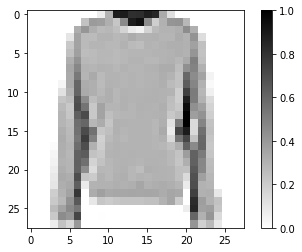

In [ ]:
#Mostrar una imagen de los datos de pruebas, de momento mostremos la primera
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((28,28)) #Redimensionar, cosas de tensores, lo veremos despues

import matplotlib.pyplot as plt

#Dibujar dibujar
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

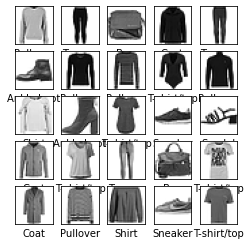

In [ ]:
#Dibujar mas
plt.figure(figsize=(4,4))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

In [ ]:
#Crear el modelo
modelo = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28,1)), #1 - blanco y negro
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax) #Para redes de clasificacion
])

In [ ]:
#Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
#Los numeros de datos en entrenamiento y pruebas (60k y 10k)
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples

In [ ]:
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [ ]:
#El trabajo por lotes permite que entrenamientos con gran cantidad de datos se haga de manera mas eficiente
TAMANO_LOTE = 32

#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria para que la red
#no se vaya a aprender el orden de las cosas
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [ ]:
import math

#Entrenar
historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch= math.ceil(num_ej_entrenamiento/TAMANO_LOTE))

Epoch 1/5
1875/1875 [==============================] - 10s 3ms/step - loss: 0.5120 - accuracy: 0.8197
Epoch 2/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3780 - accuracy: 0.8623
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3440 - accuracy: 0.8730
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3209 - accuracy: 0.8818
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3083 - accuracy: 0.8846


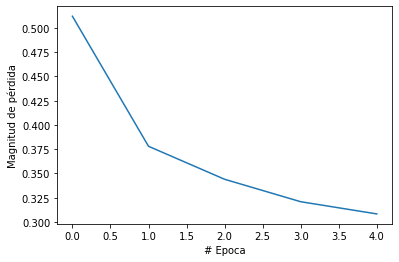

In [ ]:
#Ver la funcion de perdida
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


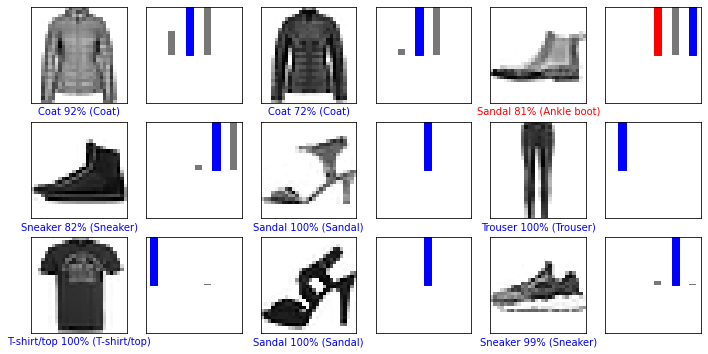

In [ ]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  
  
  predicciones = modelo.predict(imagenes_prueba)
  
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)
  
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 0]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')
  
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

# Nueva sección

In [ ]:
#Probar una imagen suelta
imagen = imagenes_prueba[4] #AL ser la variable imagenes_prueba solo tiene lo que se le puso en el bloque anterior heheh
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: " + nombres_clases[np.argmax(prediccion[0])])

Prediccion: Sandal


In [ ]:
#Exportacion del modelo a h5
modelo.save('modelo_exportado.h5')

In [ ]:
#Instalar tensorflowjs para convertir el h5 a un modelo que pueda cargar tensorflowjs en un explorador
!pip install tensorflowjs

In [ ]:
#Convertir el archivo h5 a formato de tensorflowjs
!mkdir tfjs_target_dir
!tensorflowjs_converter --input_format keras modelo_exportado.h5 tfjs_target_dir

2021-07-17 02:57:45.147570: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
#Veamos si si creo la carpeta
!ls

modelo_exportado.h5  sample_data  tfjs_target_dir


In [ ]:
#Veamos el contenido de la carpeta
!ls tfjs_target_dir

group1-shard1of1.bin  model.json
